#  YOLO Behaviour Detection - Training Notebook

This notebook trains a **YOLOv8m** model to detect:
-  Helmet
-  No Helmet
-  Alcohol
-  Cigarette

**Model**: YOLOv8m (Medium) | **Epochs**: 100 | **Platform**: Google Colab GPU

---

## 1 Setup & Mount Drive
Mount Google Drive for dataset access and backup.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Drive mounted. Listing yolo_backup:")
!ls -la /content/drive/MyDrive/yolo_backup || echo "yolo_backup not found"


Mounted at /content/drive
Drive mounted. Listing yolo_backup:
ls: cannot access '/content/drive/MyDrive/yolo_backup': No such file or directory
yolo_backup not found


In [ ]:
# CELL 1 — mount Google Drive and list the yolo_backup folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("\nListing /content/drive/MyDrive/yolo_backup (if present):\n")
!ls -la /content/drive/MyDrive/yolo_backup || echo "yolo_backup not found"


Mounted at /content/drive

Listing /content/drive/MyDrive/yolo_backup (if present):

ls: cannot access '/content/drive/MyDrive/yolo_backup': No such file or directory
yolo_backup not found


In [ ]:
# CELL — confirm shortcut visible and list files
import os
p = "/content/drive/MyDrive/yolo_backup"
print("Exists:", os.path.exists(p))
print("\nListing:")
!ls -la "/content/drive/MyDrive/yolo_backup" || echo "No files listed"


Exists: True

Listing:
lrw------- 1 root root 0 Dec 12 14:55 /content/drive/MyDrive/yolo_backup -> /content/drive/.shortcut-targets-by-id/1tx9DTs0Hlal4XtjCXW-GwZRC2YYRe-bI/yolo_backup


## 2 Configuration & Dataset
Set training parameters and verify dataset is available.

In [ ]:
import os
p = "/content/drive/MyDrive/yolo_backup"
print("Exists:", os.path.exists(p))
print("\nListing:")
!ls -la "/content/drive/MyDrive/yolo_backup" || echo "No files listed"

Exists: True

Listing:
lrw------- 1 root root 0 Dec 12 14:55 /content/drive/MyDrive/yolo_backup -> /content/drive/.shortcut-targets-by-id/1tx9DTs0Hlal4XtjCXW-GwZRC2YYRe-bI/yolo_backup


In [ ]:
# CELL 2 — list contents inside the actual shared backup folder
backup_path = "/content/drive/MyDrive/yolo_backup"

print("Listing backup folder:")
!ls -lh "$backup_path"


Listing backup folder:
lrw------- 1 root root 0 Dec 12 14:55 /content/drive/MyDrive/yolo_backup -> /content/drive/.shortcut-targets-by-id/1tx9DTs0Hlal4XtjCXW-GwZRC2YYRe-bI/yolo_backup


In [ ]:
# CELL 3 — list inside the *actual* target directory
real_path = "/content/drive/.shortcut-targets-by-id/1tx9DTs0Hlal4XtjCXW-GwZRC2YYRe-bI/yolo_backup"

print("Listing REAL backup folder:")
!ls -lh "$real_path"


Listing REAL backup folder:
total 297M
-rw------- 1 root root 149M Dec 12 11:22 best_epoch60.pt
-rw------- 1 root root 149M Dec 12 11:22 last_epoch60.pt


In [ ]:
# CELL 4 — copy resume checkpoints into /content
src = "/content/drive/.shortcut-targets-by-id/1tx9DTs0Hlal4XtjCXW-GwZRC2YYRe-bI/yolo_backup"

!cp "$src/last_epoch60.pt" /content/
!cp "$src/best_epoch60.pt" /content/

print("Copied files:")
!ls -lh /content | grep epoch60


Copied files:
-rw------- 1 root root 149M Dec 12 15:00 best_epoch60.pt
-rw------- 1 root root 149M Dec 12 15:00 last_epoch60.pt


In [ ]:
# CELL — download dataset from Kaggle (will prompt upload if kaggle.json missing)
import os, shutil, subprocess
from google.colab import files, drive

drive.mount('/content/drive', force_remount=True)
KAGGLE_DST = "/root/.kaggle/kaggle.json"
DRIVE_KAGGLE = "/content/drive/MyDrive/kaggle.json"

# ensure kaggle.json exists in runtime
if os.path.exists(KAGGLE_DST):
    print("Found kaggle.json in session:", KAGGLE_DST)
elif os.path.exists(DRIVE_KAGGLE):
    os.makedirs(os.path.dirname(KAGGLE_DST), exist_ok=True)
    shutil.copy2(DRIVE_KAGGLE, KAGGLE_DST)
    os.chmod(KAGGLE_DST, 0o600)
    print("Copied kaggle.json from Drive to", KAGGLE_DST)
else:
    print("kaggle.json not found. Please upload your kaggle.json (small file) now.")
    uploaded = files.upload()
    if "kaggle.json" in uploaded:
        os.makedirs(os.path.dirname(KAGGLE_DST), exist_ok=True)
        with open(KAGGLE_DST, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(KAGGLE_DST, 0o600)
        print("Uploaded kaggle.json to", KAGGLE_DST)
    else:
        raise FileNotFoundError("kaggle.json not provided. Upload it to proceed.")

# install kaggle and download
print("\nInstalling kaggle client...")
subprocess.check_call(["pip","install","-q","kaggle"])
os.makedirs("/content/dataset", exist_ok=True)
print("Downloading dataset (harirchandran/yolo-dataset-final) to /content/dataset ...")
rc = subprocess.call("kaggle datasets download -d harirchandran/yolo-dataset-final -p /content/dataset", shell=True)
if rc != 0:
    raise RuntimeError(f"kaggle download failed (rc={rc}). Check kaggle.json permissions and quota.")

# unzip
zip_path = "/content/dataset/yolo-dataset-final.zip"
if os.path.exists(zip_path):
    print("Unzipping dataset...")
    subprocess.check_call(["unzip","-q",zip_path,"-d","/content/dataset"])
    print("Unzip complete. Dataset available at /content/dataset/dataset_latest")
    print("\nListing dataset folder:")
    !ls -la /content/dataset/dataset_latest | sed -n '1,120p'
else:
    raise FileNotFoundError(f"{zip_path} not found after download.")


Mounted at /content/drive
kaggle.json not found. Please upload your kaggle.json (small file) now.


Saving kaggle.json to kaggle.json
Uploaded kaggle.json to /root/.kaggle/kaggle.json

Installing kaggle client...
Unzipping dataset...
Unzip complete. Dataset available at /content/dataset/dataset_latest

Listing dataset folder:
total 24
drwxr-xr-x 5 root root 4096 Dec 12 15:04 .
drwxr-xr-x 3 root root 4096 Dec 12 15:04 ..
-rw-r--r-- 1 root root  219 Dec 12 05:47 data.yaml
drwxr-xr-x 4 root root 4096 Dec 12 15:04 test
drwxr-xr-x 4 root root 4096 Dec 12 15:04 train
drwxr-xr-x 4 root root 4096 Dec 12 15:04 valid


## 3 Training
Start or resume YOLO training with configured parameters.

In [ ]:
# ONE CELL: recreate data.yaml (if missing), verify dataset, then resume auto-backup loop
TARGET_EPOCH = 100            # final total epochs you want
RUN_NAME = "continue_from60"  # run name under /content/runs/detect
PROJECT_DIR = "/content/runs/detect"
DRIVE_BACKUP_DIR = "/content/drive/MyDrive/yolo_autobackups"

import os, re, shutil, time, textwrap
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1) ensure dataset present
DATASET_DIR = "/content/dataset/dataset_latest"
if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError(f"Dataset not found at {DATASET_DIR}. Please download/unzip dataset first.")

# 2) recreate /content/data.yaml if missing
DATA_YAML = "/content/data.yaml"
if not os.path.exists(DATA_YAML):
    yaml_text = textwrap.dedent("""\
    train: /content/dataset/dataset_latest/train/images
    val:   /content/dataset/dataset_latest/valid/images
    test:  /content/dataset/dataset_latest/test/images

    nc: 4
    names: ['helmet','without_helmet','alcohol','ciggaret']
    """)
    with open(DATA_YAML, "w") as f:
        f.write(yaml_text)
    print("Created /content/data.yaml")
else:
    print("/content/data.yaml already exists")

# 3) ensure checkpoint exists locally
LOCAL_CKPT = "/content/last_epoch60.pt"
if not os.path.exists(LOCAL_CKPT):
    # fallback to any last*.pt in /content
    for fn in os.listdir("/content"):
        if fn.lower().startswith("last") and fn.lower().endswith(".pt"):
            LOCAL_CKPT = os.path.join("/content", fn)
            break
if not os.path.exists(LOCAL_CKPT):
    raise FileNotFoundError("No local checkpoint found (expected /content/last_epoch60.pt or last.pt).")

print("Using checkpoint:", LOCAL_CKPT)
print("Using data.yaml:", DATA_YAML)

# 4) determine start epoch from filename
m = re.search(r"(\d+)", os.path.basename(LOCAL_CKPT))
start_epoch = int(m.group(1)) if m else 0
print("Detected start epoch:", start_epoch)
if start_epoch >= TARGET_EPOCH:
    print("Start epoch >= TARGET_EPOCH. Nothing to do.")
else:
    os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

    # 5) Install ultralytics if missing and import
    print("Installing ultralytics (if needed)...")
    os.system("pip install -q ultralytics")
    from ultralytics import YOLO

    # 6) per-epoch resume loop with backups
    for next_epoch in range(start_epoch + 1, TARGET_EPOCH + 1):
        print(f"\n--- Running epoch {next_epoch} (resuming from {start_epoch}) ---")
        model = YOLO(LOCAL_CKPT)

        model.train(
            data=DATA_YAML,
            resume=True,
            epochs=next_epoch,
            imgsz=640,
            batch=16,
            workers=2,
            device=0,
            name=RUN_NAME,
            project=PROJECT_DIR,
            amp=True,
            optimizer="AdamW",
            lr0=0.001,
            cos_lr=True,
            patience=20,
            augment=True,
            save=True,
            verbose=True,
        )

        # locate run folder (prefer named folder)
        run_dir = os.path.join(PROJECT_DIR, RUN_NAME)
        if not os.path.exists(run_dir):
            # fallback: newest run folder
            candidates = [os.path.join(PROJECT_DIR, d) for d in os.listdir(PROJECT_DIR)] if os.path.exists(PROJECT_DIR) else []
            candidates = sorted(candidates, key=os.path.getmtime, reverse=True)
            run_dir = candidates[0] if candidates else None

        if run_dir is None:
            print("ERROR: cannot find run folder to copy weights. Stopping loop.")
            break

        weights_dir = os.path.join(run_dir, "weights")
        last_src = os.path.join(weights_dir, "last.pt")
        best_src = os.path.join(weights_dir, "best.pt")

        # backup to Drive with epoch-stamped names
        if os.path.exists(last_src):
            dst_last = os.path.join(DRIVE_BACKUP_DIR, f"last_ep{next_epoch}.pt")
            shutil.copy2(last_src, dst_last)
            print("Backed up:", last_src, "->", dst_last)
            # also update local checkpoint used for next iteration
            shutil.copy2(last_src, LOCAL_CKPT)
        else:
            print("Warning: last.pt not found at", last_src)

        if os.path.exists(best_src):
            dst_best = os.path.join(DRIVE_BACKUP_DIR, f"best_ep{next_epoch}.pt")
            shutil.copy2(best_src, dst_best)
            print("Backed up:", best_src, "->", dst_best)
        else:
            print("best.pt not found (no improvement this epoch yet)")

        # small pause
        time.sleep(2)
        start_epoch = next_epoch

    print("\nAuto-backup loop complete. Backups are in:", DRIVE_BACKUP_DIR)


Mounted at /content/drive
Created /content/data.yaml
Using checkpoint: /content/last_epoch60.pt
Using data.yaml: /content/data.yaml
Detected start epoch: 60
Installing ultralytics (if needed)...

--- Running epoch 61 (resuming from 60) ---
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixu

AssertionError: /content/last_epoch60.pt training to 100 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=/content/last_epoch60.pt'

## 4 Results & Visualization
View training metrics, confusion matrix, and sample predictions.

In [ ]:
import shutil
import os

# Define the folder where YOLO saved the results
# (Based on your logs, it is 'colab_yolov8m_100e')
source_folder = "/content/runs/detect/colab_yolov8m_100e"
output_zip = "/content/final_yolo_project"
drive_path = "/content/drive/MyDrive/final_yolo_project.zip"

print(f"📦 Zipping {source_folder}...")
shutil.make_archive(output_zip, 'zip', source_folder)

print(f"🚀 Moving to Google Drive: {drive_path}...")
shutil.copy(f"{output_zip}.zip", drive_path)

print("✅ SUCCESS! Your Project is Safe.")

📦 Zipping /content/runs/detect/colab_yolov8m_100e...
🚀 Moving to Google Drive: /content/drive/MyDrive/final_yolo_project.zip...
✅ SUCCESS! Your Project is Safe.


📊 CONFUSION MATRIX (What got confused with what):


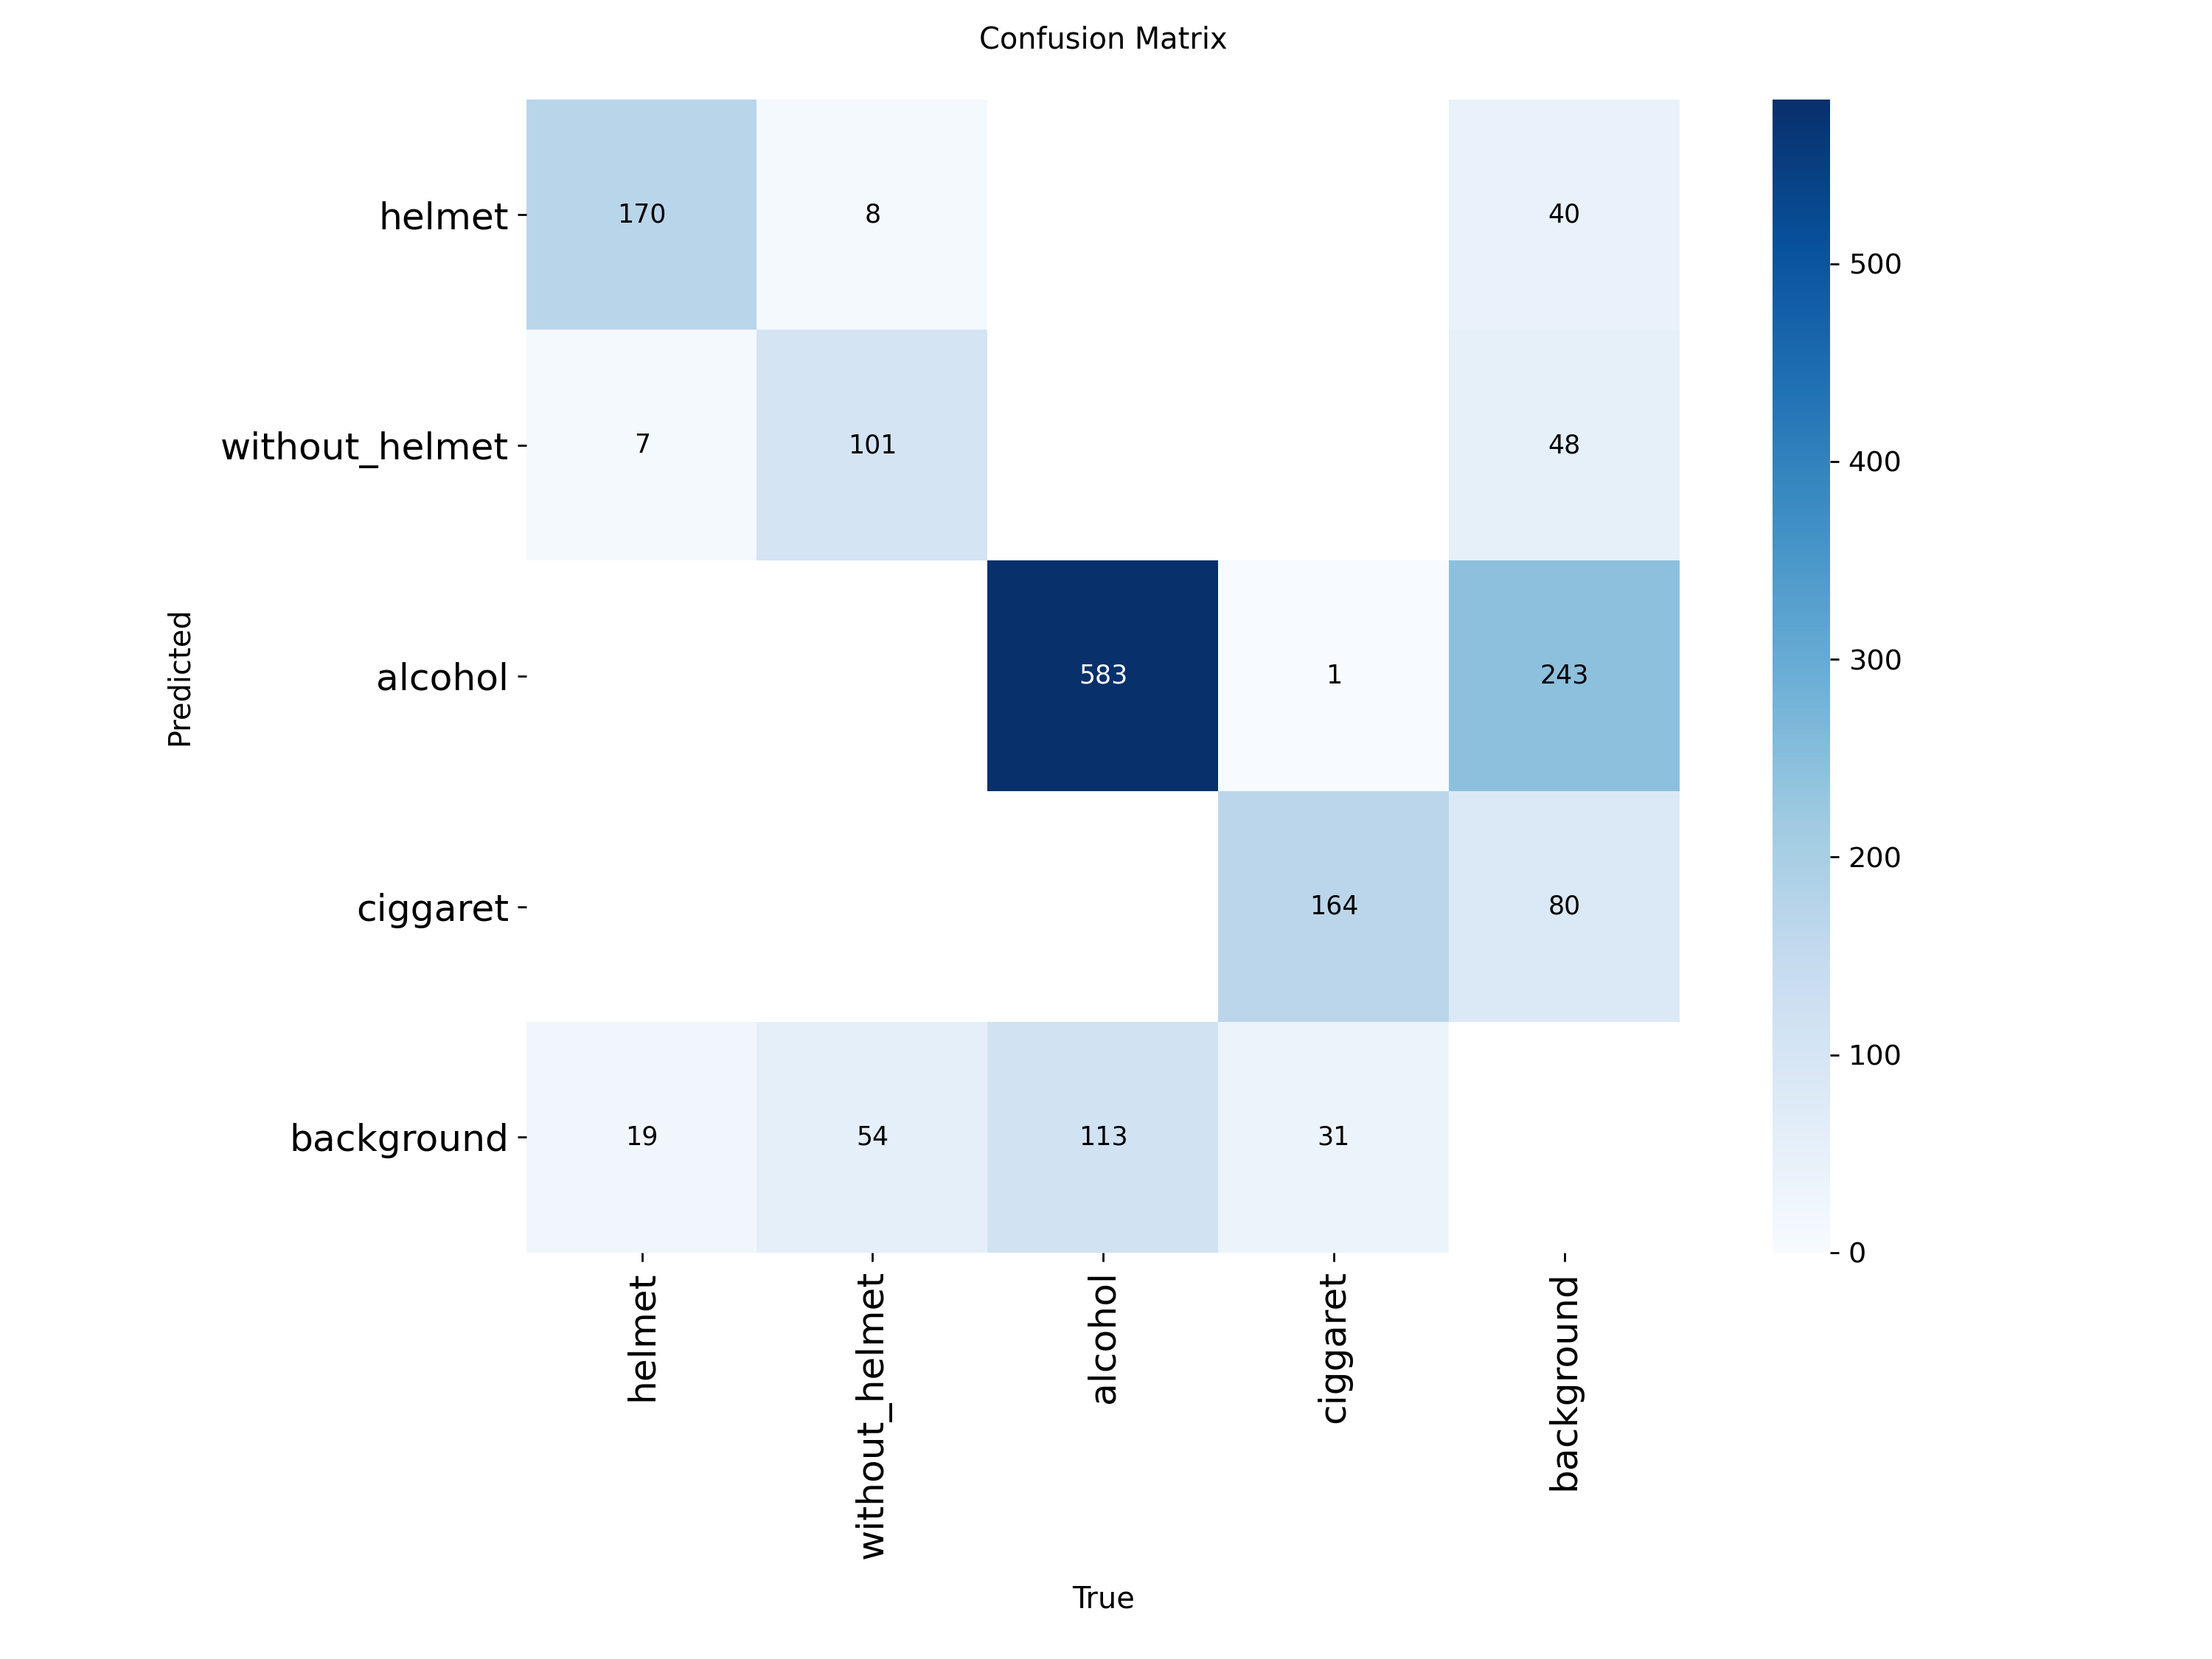


📈 TRAINING RESULTS (Loss and Accuracy over time):


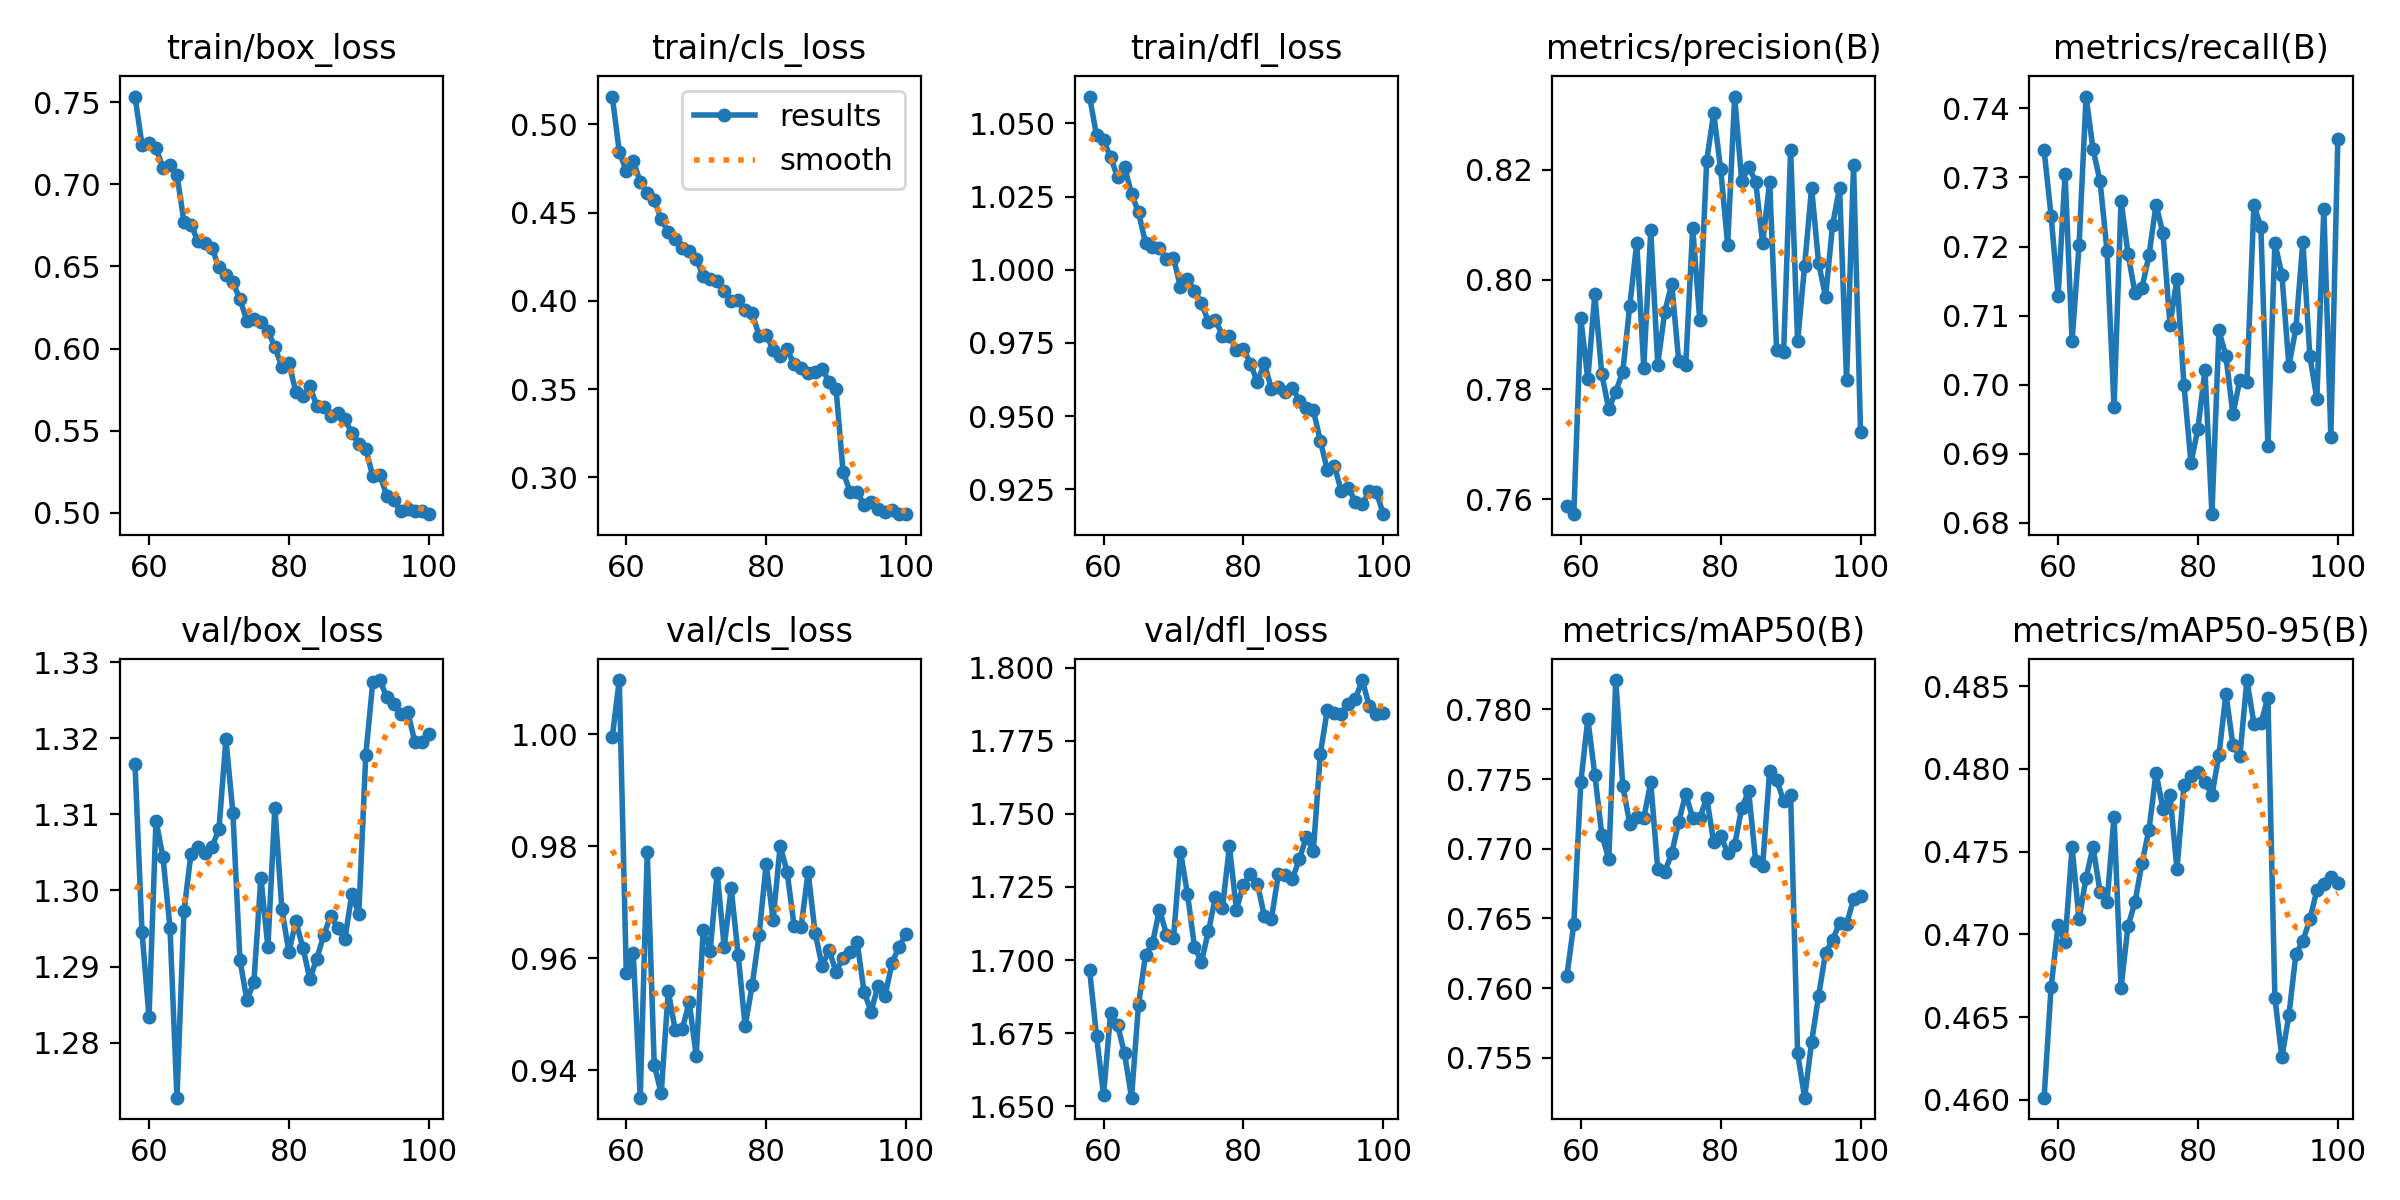


🔥 BATCH PREDICTIONS (What the model actually sees):


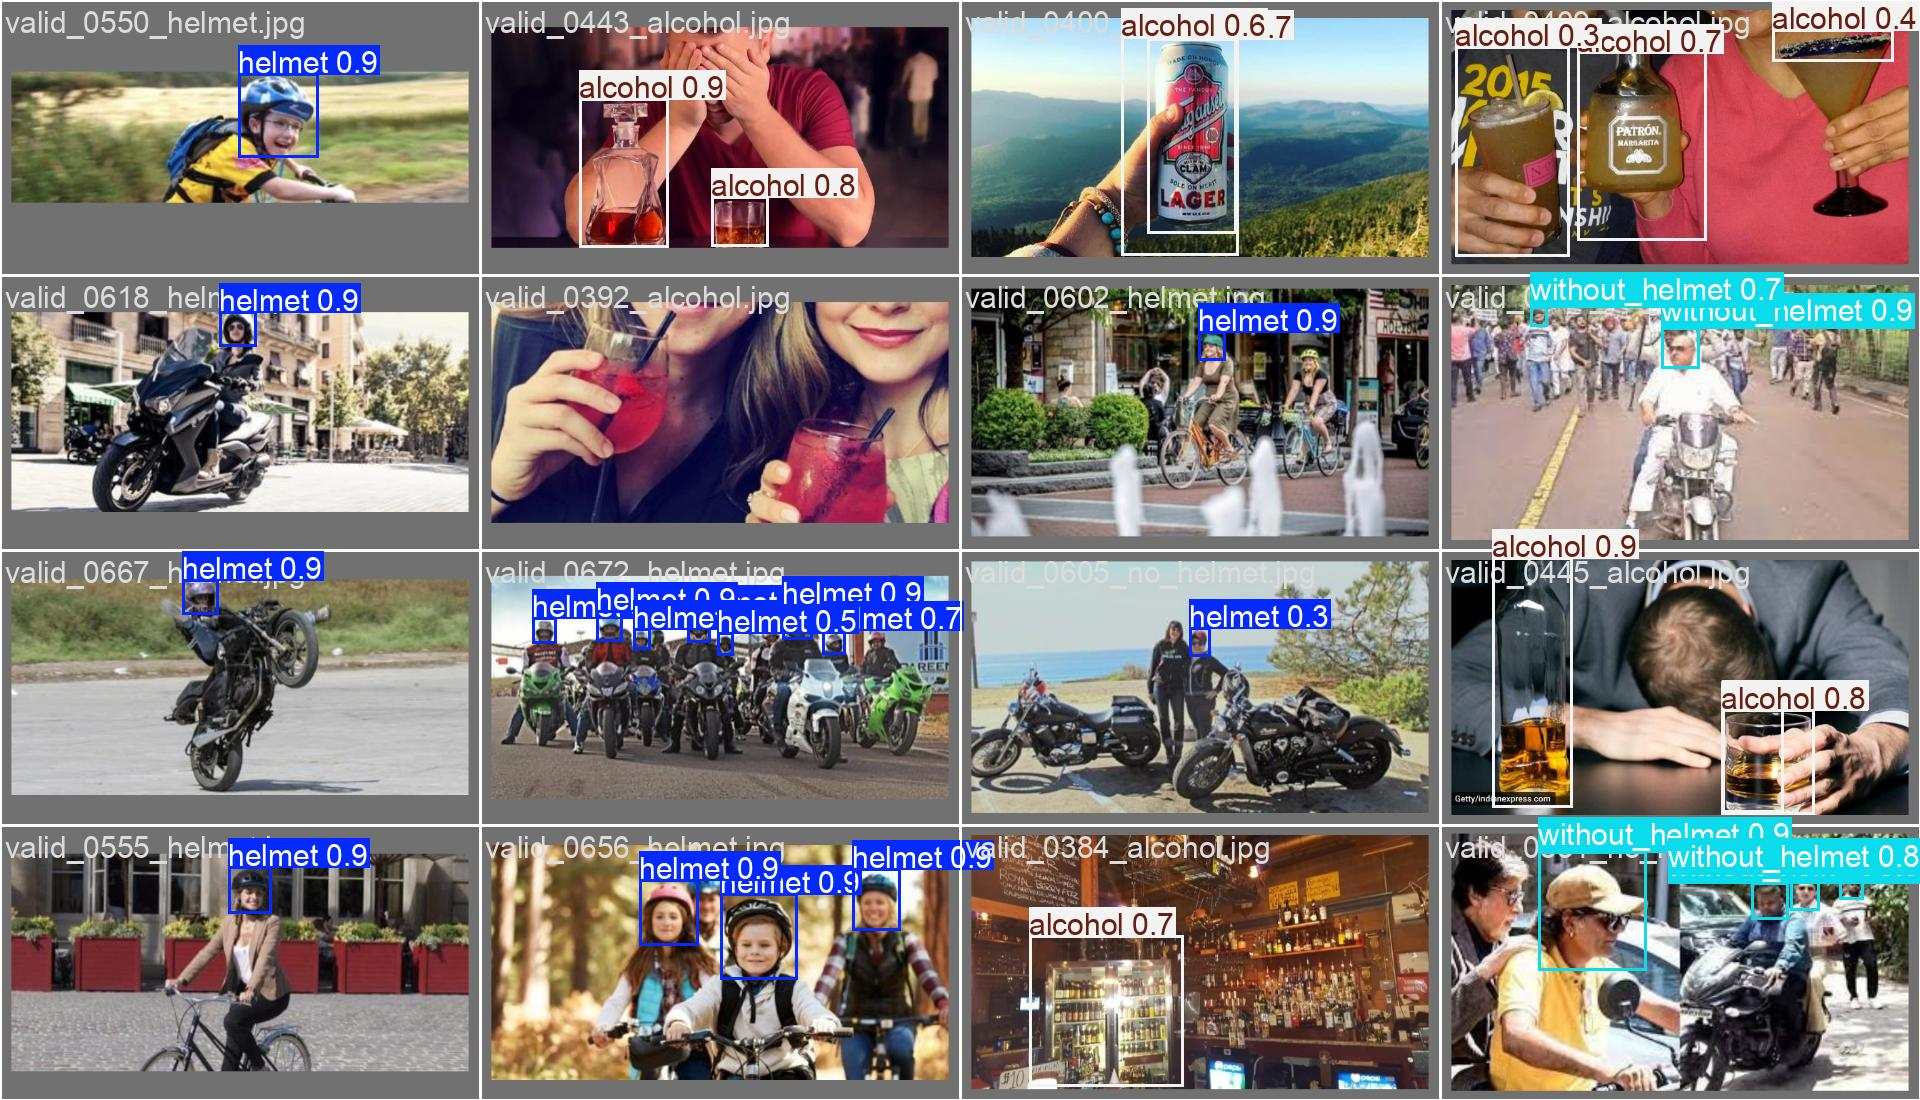

In [ ]:
from IPython.display import Image, display
import os

# Base path for your run
run_path = "/content/runs/detect/colab_yolov8m_100e"

print("📊 CONFUSION MATRIX (What got confused with what):")
display(Image(filename=f"{run_path}/confusion_matrix.png", width=800))

print("\n📈 TRAINING RESULTS (Loss and Accuracy over time):")
display(Image(filename=f"{run_path}/results.png", width=800))

print("\n🔥 BATCH PREDICTIONS (What the model actually sees):")
display(Image(filename=f"{run_path}/val_batch0_pred.jpg", width=800))

## 5 Export & Download Model
Download the trained model weights (est.pt).

In [ ]:
from google.colab import files

# Define the path to your best weights
best_model_path = "/content/runs/detect/colab_yolov8m_100e/weights/best.pt"

# Download it to your local machine
print(f"⬇️ Downloading {best_model_path}...")
files.download(best_model_path)

⬇️ Downloading /content/runs/detect/colab_yolov8m_100e/weights/best.pt...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>